# Calibration of epidemiological parameters

The values that characterize the distributions of the exposure duration $l$, incubation time $m$ and infection duration $n$ given in the literature assume independent distributions of the three values. Nevertheless, in reality in every individual these values are not independent and are subject to the constraint $1 \leq l \leq m \leq n$. If drawing values for individuals from distributions for $l$, $m$ and $n$ and rejecting value combinations that do not conform to the constraint, the distributions become left-truncated.  

To address this issue, we need to fit the values that characterize the distributions for $l$, $m$ and $n$, i.e. the shape and scale of the corresponding weibull distributions such that the shape and scale of the distributions *after* left-truncating them corresponds to the values reported in the literature. 

In the below script, we do this once for the distributions reported for the wild type variant of the SARS-CoV-2 virus and once for the omicron variant. The values for the wild type are used in the calibration of the contact parameter, since the empirical data used for the calibration stems from infection chains with the wild type variant. The values for the omicron variant are used to run the simulations on the calibrated model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
from scipy.optimize import root_scalar
from math import gamma

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

In [72]:
dst = "../../../data/simulation_results/calibration/"

**Note:** Somehow the parallelization does not work if the functions are imported from a home-brew library (i.e. `calibration_functions`) and not defined within the notebook. That's why we repeat them here.

In [2]:
def weibull_two_param(shape, scale):
    '''
    A two-parameter Weibull distribution, based on numpy ramdon's single 
    parameter distribution. We use this distribution in the simulation to draw
    random epidemiological parameters for agents from the given distribution
    See https://numpy.org/doc/stable/reference/random/generated/numpy.random.weibull.html
    '''
    return scale * np.random.weibull(shape)


def get_weibull_shape(k, mu, var):
    '''
    Calculates the shape parameter of a Weibull distribution, given its mean
    mu and its variance var
    '''
    return var / mu**2 - gamma(1 + 2/k) / gamma(1+1/k)**2 + 1



def get_weibull_scale(mu, k):
    '''
    Calculates the scale parameter of a Weibull distribution, given its mean
    mu and its shape parameter k
    '''
    return mu / gamma(1 + 1/k)

def get_true_epi_params(p):
    
    N, e, t, i, e_std, t_std, i_std = p
    curr_epi_params = {
        "exposure_duration":{"mean":e, "std":e_std},
        "time_until_symptoms":{"mean":t, "std":t_std},
        "infection_duration":{"mean":i, "std":i_std}
    }
    for param_name in curr_epi_params.keys():
        mu = curr_epi_params[param_name]["mean"]
        var = curr_epi_params[param_name]["std"]**2
        shape = root_scalar(get_weibull_shape, args=(mu, var),
                    method='toms748', bracket=[0.2, 500]).root
        scale = get_weibull_scale(mu, shape)
        curr_epi_params[param_name]["shape"] = shape
        curr_epi_params[param_name]["scale"] = scale
    
    exposure_duration = []
    time_until_symptoms = []
    infection_duration = []
    for i in range(N):
        tmp_epi_params = {}
        while True:
            for param_name in curr_epi_params.keys():
                tmp_epi_params[param_name] = \
                    round(weibull_two_param(curr_epi_params[param_name]["shape"],
                                            curr_epi_params[param_name]["scale"]))

            if (tmp_epi_params['exposure_duration'] >= 1) and \
               (tmp_epi_params['time_until_symptoms'] >= \
               tmp_epi_params['exposure_duration']) and\
               (tmp_epi_params['infection_duration'] >= \
               tmp_epi_params['time_until_symptoms']):
               break

        exposure_duration.append(tmp_epi_params['exposure_duration'])
        time_until_symptoms.append(tmp_epi_params['time_until_symptoms'])
        infection_duration.append(tmp_epi_params['infection_duration'])

    exposure_duration = np.asarray(exposure_duration)
    time_until_symptoms = np.asarray(time_until_symptoms)
    infection_duration = np.asarray(infection_duration)
    
    row = {
        'e_mean':curr_epi_params["exposure_duration"]["mean"],
        'e_std':curr_epi_params["exposure_duration"]["std"],
        't_mean':curr_epi_params["time_until_symptoms"]["mean"],
        't_std':curr_epi_params["time_until_symptoms"]["std"],
        'i_mean':curr_epi_params["infection_duration"]["mean"],
        'i_std':curr_epi_params["infection_duration"]["std"],
        'true_e_mean':exposure_duration.mean(),
        'true_e_std':exposure_duration.std(),
        'true_t_mean':time_until_symptoms.mean(),
        'true_t_std':time_until_symptoms.std(),
        'true_i_mean':infection_duration.mean(),
        'true_i_std':infection_duration.std()
    }
    return row

## Wild type

In [3]:
expected_epi_params = {
    "exposure_duration":{"mean":5.0, "std":1.9},
    "time_until_symptoms":{"mean":6.4, "std":0.8},
    "infection_duration":{"mean":10.91, "std":3.95}
}

### Coarse grid search

In [4]:
N = 1000
step = 0.2
exposure_durations = np.arange(4.5, 7.5 + step, step)
times_until_symtoms = np.arange(5.6, 7 + step, step)
infection_durations = np.arange(8.5, 10.0 + step, step)

step = 0.25
exposure_duration_stds = np.arange(1.5, 2.4 + step, step)
times_until_symtoms_stds = np.arange(0.2, 1.4 + step, step)
infection_durations_stds = np.arange(3, 5 + step * 2, step * 2)

param_combinations = [(N, e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

194400 parameter combinations


In [ ]:
results = pd.DataFrame()

pool = Pool(10)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results = results.append(row, ignore_index=True)
pool.close()

results["e_mean_diff"] = results["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results["e_std_diff"] = results["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results["t_mean_diff"] = results["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results["t_std_diff"] = results["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results["i_mean_diff"] = results["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results["i_std_diff"] = results["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results["mean_diff"] = results["e_mean_diff"] + results["t_mean_diff"] + results["i_mean_diff"]
results["std_diff"] = results["e_std_diff"] + results["t_std_diff"] + results["i_std_diff"]
results["diff"] = results["mean_diff"] + results["std_diff"]

fname = "calibration_epidemiological_parameters_results_coarse_wt.csv.xz"
results.to_csv(join(dst, fname), index=False)

  0%|                                                                                                                                          | 0/194400 [00:00<?, ?it/s]


In [75]:
fname = "calibration_epidemiological_parameters_results_coarse_wt.csv.xz"
results = pd.read_csv(join(dst, fname), compression="xz")

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results[col] = results[col].apply(lambda x: round(x, 2))

In [76]:
idx_best = results["diff"].idxmin()
best_e_mean = results.loc[idx_best, "e_mean"]
best_e_std = results.loc[idx_best, "e_std"]
best_t_mean = results.loc[idx_best, "t_mean"]
best_t_std = results.loc[idx_best, "t_std"]
best_i_mean = results.loc[idx_best, "i_mean"]
best_i_std = results.loc[idx_best, "i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")

best e: [(6.9, 2.5)]
best t: [(6.2, 1.2)]
best i: [(8.9, 4.5)]


In [7]:
exposure_durations = [round(e, 2) for e in exposure_durations]
times_until_symtoms = [round(t, 2) for t in times_until_symtoms]

selected_infection_durations = [ 8.5,  8.7,  8.9,  9.1,  9.3,  9.5,  9.7,  9.9, 10.1]
images = {i:np.zeros((len(exposure_durations), len(times_until_symtoms))) \
          for i in selected_infection_durations}


results = results.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])
for infection_duration in selected_infection_durations:
    for i, e in enumerate(exposure_durations):
        for j, t in enumerate(times_until_symtoms):
            images[infection_duration][i, j] = \
                results.loc[e, t, infection_duration, best_e_std, best_t_std, best_i_std]["diff"]
results = results.reset_index()

In [8]:
results["diff"].max()

8.279124833476608

In [9]:
results["diff"].min()

0.2031488097306147

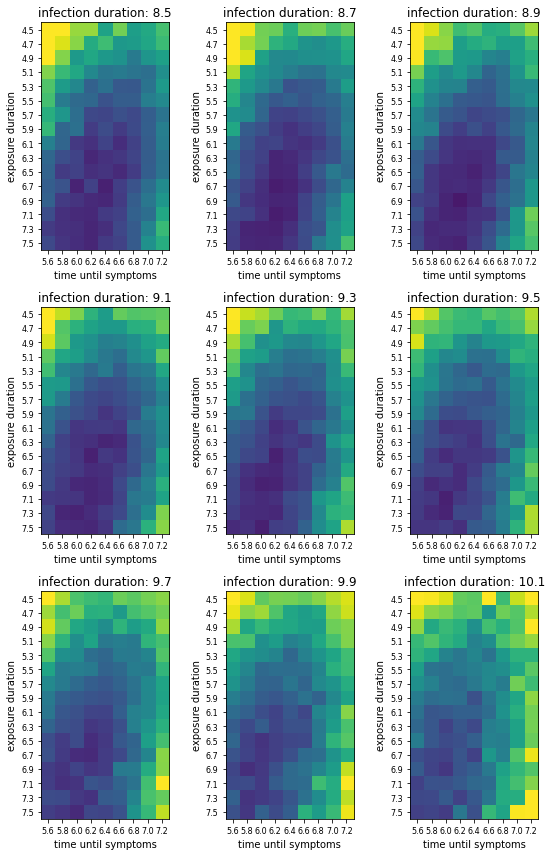

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(8, 12))
for ax, infection_duration in zip(axes.flatten(), selected_infection_durations):
    ax.imshow(images[infection_duration], vmin=0, vmax=3)
    ax.set_yticks(range(len(exposure_durations)))
    ax.set_yticklabels(exposure_durations, fontsize=8)
    ax.set_xticks(range(len(times_until_symtoms)))
    ax.set_xticklabels(times_until_symtoms, fontsize=8)
    ax.set_xlabel("time until symptoms")
    ax.set_ylabel("exposure duration")
    ax.set_title(f"infection duration: {infection_duration}")
fig.tight_layout()

### Fine grid search

In [77]:
fname = "calibration_epidemiological_parameters_results_coarse_wt.csv.xz"
results = pd.read_csv(join(dst, fname), compression="xz")

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results[col] = results[col].apply(lambda x: round(x, 2))

In [78]:
idx_best = results["diff"].idxmin()
best_e_mean = results.loc[idx_best, "e_mean"]
best_e_std = results.loc[idx_best, "e_std"]
best_t_mean = results.loc[idx_best, "t_mean"]
best_t_std = results.loc[idx_best, "t_std"]
best_i_mean = results.loc[idx_best, "i_mean"]
best_i_std = results.loc[idx_best, "i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")

best e: [(6.9, 2.5)]
best t: [(6.2, 1.2)]
best i: [(8.9, 4.5)]


In [13]:
N = 10000
step = 0.05
window = 0.25
exposure_durations = np.arange(best_e_mean - window, best_e_mean + window + step, step)
times_until_symtoms = np.arange(best_t_mean - window, best_t_mean + window + step, step)
infection_durations = np.arange(best_i_mean - window, best_i_mean + window + step, step)

step = 0.1
exposure_duration_stds = np.arange(best_e_std - window, best_e_std + window + step, step)
times_until_symtoms_stds = np.arange(best_t_std - window, best_t_std + window + step, step)
infection_durations_stds = np.arange(best_i_std - window, best_i_std + window + step, step)

param_combinations = [(N, e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

426888 parameter combinations


In [8]:
results_fine = pd.DataFrame()

pool = Pool(250)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results_fine = results_fine.append(row, ignore_index=True)
pool.close()

results_fine["e_mean_diff"] = results_fine["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results_fine["e_std_diff"] = results_fine["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results_fine["t_mean_diff"] = results_fine["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results_fine["t_std_diff"] = results_fine["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results_fine["i_mean_diff"] = results_fine["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results_fine["i_std_diff"] = results_fine["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results_fine["mean_diff"] = results_fine["e_mean_diff"] + results_fine["t_mean_diff"] + results_fine["i_mean_diff"]
results_fine["std_diff"] = results_fine["e_std_diff"] + results_fine["t_std_diff"] + results_fine["i_std_diff"]
results_fine["diff"] = results_fine["mean_diff"] + results_fine["std_diff"]

fname = "calibration_epidemiological_parameters_results_fine_wt.csv.xz"
results_fine.to_csv(join(dst, fname), index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 426888/426888 [51:52<00:00, 137.15it/s]


In [81]:
fname = "calibration_epidemiological_parameters_results_fine_wt.csv.xz"
results_fine = pd.read_csv(join(dst, fname), compression="xz")

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results_fine[col] = results_fine[col].apply(lambda x: round(x, 2))

In [82]:
idx_best_fine = results_fine["diff"].idxmin()
best_e_mean_fine = results_fine.loc[idx_best, "e_mean"]
best_e_std_fine = results_fine.loc[idx_best_fine, "e_std"]
best_t_mean_fine = results_fine.loc[idx_best_fine, "t_mean"]
best_t_std_fine = results_fine.loc[idx_best_fine, "t_std"]
best_i_mean_fine = results_fine.loc[idx_best_fine, "i_mean"]
best_i_std_fine = results_fine.loc[idx_best_fine, "i_std"]

true_e_mean_fine = results_fine.loc[idx_best_fine, "true_e_mean"]
true_e_std_fine = results_fine.loc[idx_best_fine, "true_e_std"]
true_t_mean_fine = results_fine.loc[idx_best_fine, "true_t_mean"]
true_t_std_fine = results_fine.loc[idx_best_fine, "true_t_std"]
true_i_mean_fine = results_fine.loc[idx_best_fine, "true_i_mean"]
true_i_std_fine = results_fine.loc[idx_best_fine, "true_i_std"]

print(f"best e: [{best_e_mean_fine, best_e_std_fine}]")
print(f"best t: [{best_t_mean_fine, best_t_std_fine}]")
print(f"best i: [{best_i_mean_fine, best_i_std_fine}]")
print()
print(f"true e: [{true_e_mean_fine, true_e_std_fine}]")
print(f"true t: [{true_t_mean_fine, true_t_std_fine}]")
print(f"true i: [{true_i_mean_fine, true_i_std_fine}]")

best e: [(6.8, 2.75)]
best t: [(6.3, 0.95)]
best i: [(8.65, 4.75)]

true e: [(4.8525, 1.559212541637605)]
true t: [(6.476, 0.90951855396138)]
true i: [(10.9887, 3.868691291638556)]


In [17]:
for param_name, param, param_std in zip(["e", "t", "i"], \
                [best_e_mean_fine, best_t_mean_fine, best_i_mean_fine],\
                [best_e_std_fine, best_t_std_fine, best_i_std_fine]):
    mu = param
    var = param_std**2
    shape = root_scalar(get_weibull_shape, args=(mu, var),
                method='toms748', bracket=[0.2, 500]).root
    scale = get_weibull_scale(mu, shape)

    print(f"{param_name}: shape: {shape}, scale: {scale}")

e: shape: 2.662794506920476, scale: 7.6501507255486025
t: shape: 7.862375357983137, scale: 6.695392007737956
i: shape: 1.8935596294478323, scale: 9.746904881250568


In [18]:
exposure_durations = [round(e, 2) for e in exposure_durations]
times_until_symtoms = [round(t, 2) for t in times_until_symtoms]

selected_infection_durations = [round(i, 2) for i in infection_durations]
images = {i:np.zeros((len(exposure_durations), len(times_until_symtoms))) \
          for i in selected_infection_durations}


results_fine = results_fine.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])
for infection_duration in selected_infection_durations:
    for i, e in enumerate(exposure_durations):
        for j, t in enumerate(times_until_symtoms):
            images[infection_duration][i, j] = \
                results_fine.loc[e, t, infection_duration, best_e_std_fine, best_t_std_fine, best_i_std_fine]["diff"]
results_fine = results_fine.reset_index()

In [19]:
results_fine["diff"].max()

1.4394534184114165

In [20]:
results_fine["diff"].min()

0.1684674514942989

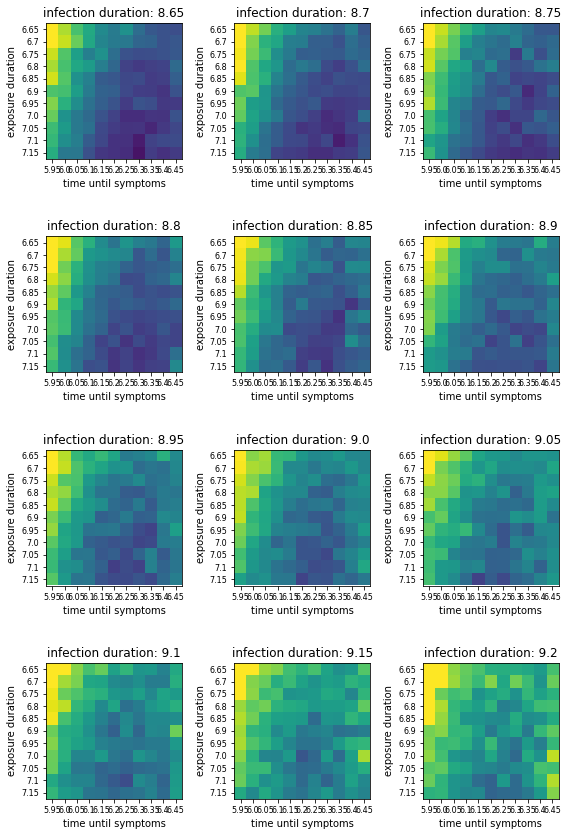

In [21]:
fig, axes = plt.subplots(4, 3, figsize=(8, 12))
for ax, infection_duration in zip(axes.flatten(), selected_infection_durations):
    ax.imshow(images[infection_duration], vmin=0.15, vmax=0.5)
    ax.set_yticks(range(len(exposure_durations)))
    ax.set_yticklabels(exposure_durations, fontsize=8)
    ax.set_xticks(range(len(times_until_symtoms)))
    ax.set_xticklabels(times_until_symtoms, fontsize=8)
    ax.set_xlabel("time until symptoms")
    ax.set_ylabel("exposure duration")
    ax.set_title(f"infection duration: {infection_duration}")
fig.tight_layout()

### Epi parameter distribution plot

In [22]:
curr_epi_params = {
        "exposure_duration":{"mean":best_e_mean_fine, "std":best_e_std_fine},
        "time_until_symptoms":{"mean":best_t_mean_fine, "std":best_t_std_fine},
        "infection_duration":{"mean":best_i_mean_fine, "std":best_i_std_fine}
    }
for param_name in curr_epi_params.keys():
    mu = curr_epi_params[param_name]["mean"]
    var = curr_epi_params[param_name]["std"]**2
    shape = root_scalar(get_weibull_shape, args=(mu, var),
                method='toms748', bracket=[0.2, 500]).root
    scale = get_weibull_scale(mu, shape)
    curr_epi_params[param_name]["shape"] = shape
    curr_epi_params[param_name]["scale"] = scale

exposure_duration = []
time_until_symptoms = []
infection_duration = []
for i in range(10000):
    tmp_epi_params = {}
    while True:
        for param_name in curr_epi_params.keys():
            tmp_epi_params[param_name] = \
                round(weibull_two_param(curr_epi_params[param_name]["shape"],
                                        curr_epi_params[param_name]["scale"]))

        if (tmp_epi_params['exposure_duration'] >= 1) and \
           (tmp_epi_params['time_until_symptoms'] >= \
           tmp_epi_params['exposure_duration']) and\
           (tmp_epi_params['infection_duration'] >= \
           tmp_epi_params['time_until_symptoms']):
           break

    exposure_duration.append(tmp_epi_params['exposure_duration'])
    time_until_symptoms.append(tmp_epi_params['time_until_symptoms'])
    infection_duration.append(tmp_epi_params['infection_duration'])

exposure_duration = np.asarray(exposure_duration)
time_until_symptoms = np.asarray(time_until_symptoms)
infection_duration = np.asarray(infection_duration)

Text(0.7162, 0.9, 'C')

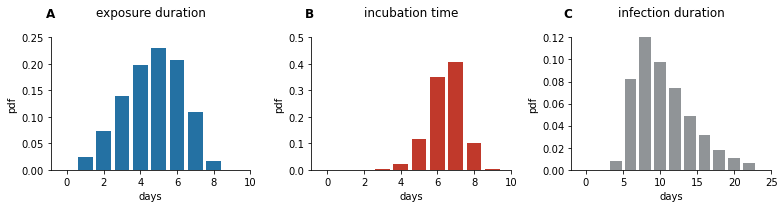

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
fig.subplots_adjust(wspace=0.3)
max_bins = [11, 11, 26]
steps = [1, 1, 2]
colors = ['#2471A3', '#C0392B', '#909497']
xticks = [range(0, 11, 2), range(0, 11, 2), range(0, 26, 5)]
labels = ['exposure duration\n', 'incubation time\n', 'infection duration\n']
ymaxes = [0.25, 0.5, 0.12]

for ax, max_bin, step, color, xtick, label, ymax, param in zip(axes, max_bins, steps, colors,\
    xticks, labels, ymaxes, [exposure_duration, time_until_symptoms, infection_duration]):
    ax.hist(param, bins=range(0, max_bin, step), rwidth=0.8, color=color,
            density=True, align='left')
    ax.set_xticks(xtick)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(label)
    ax.set_ylabel('pdf')
    ax.set_xlabel('days')
    ax.set_ylim(0, ymax)

fig.tight_layout()
fig.text(0.062, 0.9, 'A', fontsize=12, fontweight='bold')
fig.text(0.39, 0.9, 'B', fontsize=12, fontweight='bold')
fig.text(0.7162, 0.9, 'C', fontsize=12, fontweight='bold')

## Omicron

In [83]:
expected_epi_params = {
    "exposure_duration":{"mean":2, "std":1.9},
    "time_until_symptoms":{"mean":3, "std":1.9},
    "infection_duration":{"mean":10.91, "std":3.95}
}

### Coarse grid search

In [84]:
N = 1000
step = 0.2
exposure_durations = np.arange(1.4, 4 + step, step)
times_until_symtoms = np.arange(1, 3 + step, step)
infection_durations = np.arange(10, 11.4 + step, step)

step = 0.25
exposure_duration_stds = np.arange(2.0, 3.0 + step, step)
times_until_symtoms_stds = np.arange(1.5, 2.4 + step, step)
infection_durations_stds = np.arange(3, 5 + step * 2, step * 2)

param_combinations = [(N, e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

154000 parameter combinations


In [51]:
results = pd.DataFrame()

pool = Pool(200)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results = results.append(row, ignore_index=True)
pool.close()

results["e_mean_diff"] = results["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results["e_std_diff"] = results["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results["t_mean_diff"] = results["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results["t_std_diff"] = results["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results["i_mean_diff"] = results["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results["i_std_diff"] = results["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results["mean_diff"] = results["e_mean_diff"] + results["t_mean_diff"] + results["i_mean_diff"]
results["std_diff"] = results["e_std_diff"] + results["t_std_diff"] + results["i_std_diff"]
results["diff"] = results["mean_diff"] + results["std_diff"]

fname = "calibration_epidemiological_parameters_results_coarse.csv.xz"
results.to_csv(join(dst, fname), index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154000/154000 [11:12<00:00, 228.98it/s]


In [88]:
fname = "calibration_epidemiological_parameters_results_coarse.csv.xz"
results = pd.read_csv(join(dst, fname), compression="xz")
round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results[col] = results[col].apply(lambda x: round(x, 2))

In [89]:
idx_best = results["diff"].idxmin()
best_e_mean = results.loc[idx_best, "e_mean"]
best_e_std = results.loc[idx_best, "e_std"]
best_t_mean = results.loc[idx_best, "t_mean"]
best_t_std = results.loc[idx_best, "t_std"]
best_i_mean = results.loc[idx_best, "i_mean"]
best_i_std = results.loc[idx_best, "i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")

best e: [(3.6, 3.0)]
best t: [(1.8, 2.0)]
best i: [(10.8, 4.0)]


In [28]:
exposure_durations = [round(e, 2) for e in exposure_durations]
times_until_symtoms = [round(t, 2) for t in times_until_symtoms]

selected_infection_durations = [round(i, 2) for i in infection_durations]
images = {i:np.zeros((len(exposure_durations), len(times_until_symtoms))) \
          for i in selected_infection_durations}


results = results.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])
for infection_duration in selected_infection_durations:
    for i, e in enumerate(exposure_durations):
        for j, t in enumerate(times_until_symtoms):
            images[infection_duration][i, j] = \
                results.loc[e, t, infection_duration, best_e_std, best_t_std, best_i_std]["diff"]
results = results.reset_index()

In [29]:
results["diff"].max()

5.852104715496047

In [30]:
results_fine["diff"].min()

0.1684674514942989

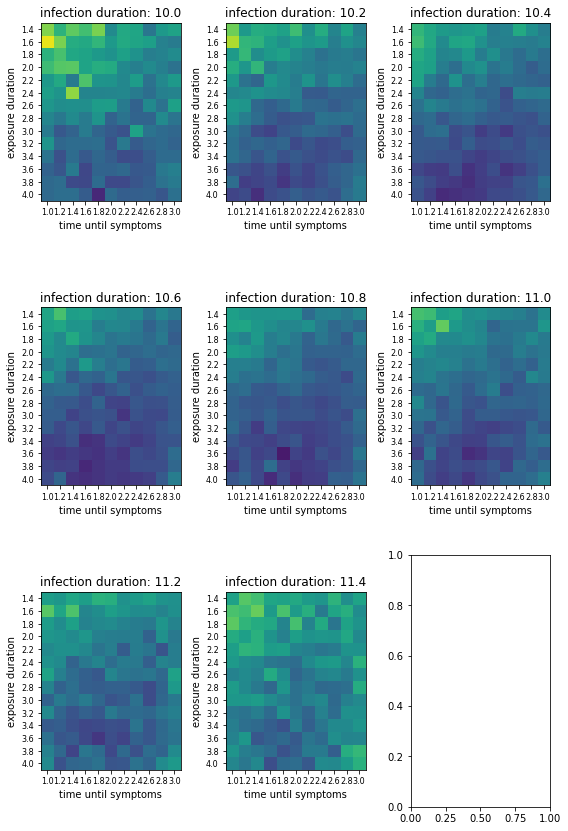

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(8, 12))
for ax, infection_duration in zip(axes.flatten(), selected_infection_durations):
    ax.imshow(images[infection_duration], vmin=0.15, vmax=3)
    ax.set_yticks(range(len(exposure_durations)))
    ax.set_yticklabels(exposure_durations, fontsize=8)
    ax.set_xticks(range(len(times_until_symtoms)))
    ax.set_xticklabels(times_until_symtoms, fontsize=8)
    ax.set_xlabel("time until symptoms")
    ax.set_ylabel("exposure duration")
    ax.set_title(f"infection duration: {infection_duration}")
fig.tight_layout()

In [32]:
idx_best = results["diff"].idxmin()
best_e_mean = results.loc[idx_best, "e_mean"]
best_e_std = results.loc[idx_best, "e_std"]
best_t_mean = results.loc[idx_best, "t_mean"]
best_t_std = results.loc[idx_best, "t_std"]
best_i_mean = results.loc[idx_best, "i_mean"]
best_i_std = results.loc[idx_best, "i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")

best e: [(3.6, 3.0)]
best t: [(1.8, 2.0)]
best i: [(10.8, 4.0)]


### Fine grid search

In [92]:
fname = "calibration_epidemiological_parameters_results_coarse.csv.xz"
results = pd.read_csv(join(dst, fname), compression="xz")

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results[col] = results[col].apply(lambda x: round(x, 2))

In [93]:
idx_best = results["diff"].idxmin()
best_e_mean = results.loc[idx_best, "e_mean"]
best_e_std = results.loc[idx_best, "e_std"]
best_t_mean = results.loc[idx_best, "t_mean"]
best_t_std = results.loc[idx_best, "t_std"]
best_i_mean = results.loc[idx_best, "i_mean"]
best_i_std = results.loc[idx_best, "i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")

best e: [(3.6, 3.0)]
best t: [(1.8, 2.0)]
best i: [(10.8, 4.0)]


In [94]:
N = 10000
step = 0.05
window = 0.25
exposure_durations = np.arange(best_e_mean_fine - 0.1, best_e_mean_fine + window * 3 + step * 2, step)
times_until_symtoms = np.arange(best_t_mean_fine - window, best_t_mean_fine + window + step, step)
infection_durations = np.arange(best_i_mean_fine + step, best_i_mean_fine + window + step, step * 2)

step = 0.1
exposure_duration_stds = np.arange(best_e_std_fine - window, best_e_std_fine + window + step, step)
times_until_symtoms_stds = np.arange(best_t_std_fine - window, best_t_std_fine + window + step, step)
infection_durations_stds = np.arange(best_i_std_fine - window, best_i_std_fine + window + step, step)

param_combinations = [(N, e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

184338 parameter combinations


In [116]:
results_fine = pd.DataFrame()

pool = Pool(200)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results_fine = results_fine.append(row, ignore_index=True)
pool.close()

results_fine["e_mean_diff"] = results_fine["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results_fine["e_std_diff"] = results_fine["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results_fine["t_mean_diff"] = results_fine["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results_fine["t_std_diff"] = results_fine["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results_fine["i_mean_diff"] = results_fine["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results_fine["i_std_diff"] = results_fine["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results_fine["mean_diff"] = results_fine["e_mean_diff"] + results_fine["t_mean_diff"] + results_fine["i_mean_diff"]
results_fine["std_diff"] = results_fine["e_std_diff"] + results_fine["t_std_diff"] + results_fine["i_std_diff"]
results_fine["diff"] = results_fine["mean_diff"] + results_fine["std_diff"]

fname = "calibration_epidemiological_parameters_results_fine.csv.xz"
results_fine.to_csv(join(dst, fname), index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 184338/184338 [21:49<00:00, 140.75it/s]


In [97]:
fname = "calibration_epidemiological_parameters_results_fine.csv.xz"
results_fine = pd.read_csv(join(dst, fname), compression="xz")

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results_fine[col] = results_fine[col].apply(lambda x: round(x, 2))

In [98]:
idx_best_fine = results_fine["diff"].idxmin()
best_e_mean_fine = results_fine.loc[idx_best_fine, "e_mean"]
best_e_std_fine = results_fine.loc[idx_best_fine, "e_std"]
best_t_mean_fine = results_fine.loc[idx_best_fine, "t_mean"]
best_t_std_fine = results_fine.loc[idx_best_fine, "t_std"]
best_i_mean_fine = results_fine.loc[idx_best_fine, "i_mean"]
best_i_std_fine = results_fine.loc[idx_best_fine, "i_std"]

true_e_mean_fine = results_fine.loc[idx_best_fine, "true_e_mean"]
true_e_std_fine = results_fine.loc[idx_best_fine, "true_e_std"]
true_t_mean_fine = results_fine.loc[idx_best_fine, "true_t_mean"]
true_t_std_fine = results_fine.loc[idx_best_fine, "true_t_std"]
true_i_mean_fine = results_fine.loc[idx_best_fine, "true_i_mean"]
true_i_std_fine = results_fine.loc[idx_best_fine, "true_i_std"]

print(f"best e: [{best_e_mean_fine, best_e_std_fine}]")
print(f"best t: [{best_t_mean_fine, best_t_std_fine}]")
print(f"best i: [{best_i_mean_fine, best_i_std_fine}]")
print()
print(f"true e: [{true_e_mean_fine, true_e_std_fine}]")
print(f"true t: [{true_t_mean_fine, true_t_std_fine}]")
print(f"true i: [{true_i_mean_fine, true_i_std_fine}]")

best e: [(4.15, 3.05)]
best t: [(1.6, 1.85)]
best i: [(10.65, 4.05)]

true e: [(1.9929, 1.32817528587156)]
true t: [(3.1759, 2.0992758727713707)]
true i: [(10.9401, 3.937475331986221)]


In [55]:
for param_name, param, param_std in zip(["e", "t", "i"], \
                [best_e_mean_fine, best_t_mean_fine, best_i_mean_fine],\
                [best_e_std_fine, best_t_std_fine, best_i_std_fine]):
    mu = param
    var = param_std**2
    shape = root_scalar(get_weibull_shape, args=(mu, var),
                method='toms748', bracket=[0.2, 500]).root
    scale = get_weibull_scale(mu, shape)

    print(f"{param_name}: shape: {shape}, scale: {scale}")

e: shape: 1.3771321157149656, scale: 4.54121146492959
t: shape: 0.8676460015047511, scale: 1.4891944517243365
i: shape: 2.85217321247462, scale: 11.951658643348956


In [56]:
exposure_durations = [round(e, 2) for e in exposure_durations]
times_until_symtoms = [round(t, 2) for t in times_until_symtoms]

selected_infection_durations = [10.55, 10.65, 10.75, 10.85, 10.95, 11.05]
images = {i:np.zeros((len(exposure_durations), len(times_until_symtoms))) \
          for i in selected_infection_durations}

exposure_durations = results_fine["e_mean"].unique()
times_until_symptoms = results_fine["t_mean"].unique()

results_fine = results_fine.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])
for infection_duration in selected_infection_durations:
    for i, e in enumerate(exposure_durations):
        for j, t in enumerate(times_until_symptoms):
            images[infection_duration][i, j] = \
                results_fine.loc[e, t, infection_duration, best_e_std_fine, best_t_std_fine, best_i_std_fine]["diff"]
results_fine = results_fine.reset_index()

In [57]:
results_fine["diff"].max()

2.0652120534849514

In [58]:
results_fine["diff"].min()

0.3987484744657188

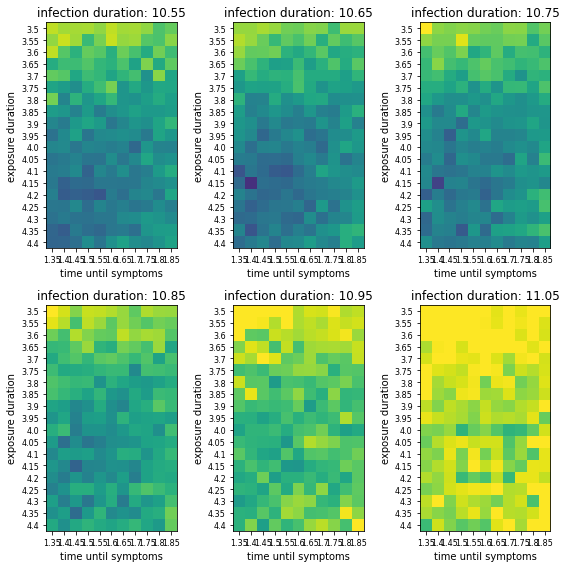

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(8, 8))
for ax, infection_duration in zip(axes.flatten(), selected_infection_durations):
    ax.imshow(images[infection_duration], vmin=0.35, vmax=0.7)
    ax.set_yticks(range(len(exposure_durations)))
    ax.set_yticklabels(exposure_durations, fontsize=8)
    ax.set_xticks(range(len(times_until_symtoms)))
    ax.set_xticklabels(times_until_symtoms, fontsize=8)
    ax.set_xlabel("time until symptoms")
    ax.set_ylabel("exposure duration")
    ax.set_title(f"infection duration: {infection_duration}")
fig.tight_layout()

### Very fine grid search

In [99]:
fname = "calibration_epidemiological_parameters_results_fine.csv.xz"
results_fine = pd.read_csv(join(dst, fname), compression="xz")

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results_fine[col] = results_fine[col].apply(lambda x: round(x, 2))

In [100]:
idx_best_fine = results["diff"].idxmin()
best_e_mean_fine = results_fine.loc[idx_best_fine, "e_mean"]
best_e_std_fine = results_fine.loc[idx_best_fine, "e_std"]
best_t_mean_fine = results_fine.loc[idx_best_fine, "t_mean"]
best_t_std_fine = results_fine.loc[idx_best_fine, "t_std"]
best_i_mean_fine = results_fine.loc[idx_best_fine, "i_mean"]
best_i_std_fine = results_fine.loc[idx_best_fine, "i_std"]

print(f"best e: [{best_e_mean_fine, best_e_std_fine}]")
print(f"best t: [{best_t_mean_fine, best_t_std_fine}]")
print(f"best i: [{best_i_mean_fine, best_i_std_fine}]")

best e: [(4.1, 2.85)]
best t: [(2.05, 1.85)]
best i: [(10.65, 4.25)]


In [101]:
N = 50000
step = 0.01
window = 0.1
exposure_durations = np.arange(best_e_mean_fine - window, best_e_mean_fine + window * 2 + step, step)
times_until_symtoms = np.arange(1.4, 1.7, step)
infection_durations = [best_i_mean_fine]

step = 0.1
exposure_duration_stds = np.arange(best_e_std_fine - window, best_e_std_fine + window + step, step)
times_until_symtoms_stds = np.arange(best_t_std_fine - window, best_t_std_fine + window + step, step)
infection_durations_stds = np.arange(best_i_std_fine - window, best_i_std_fine + window + step, step)

param_combinations = [(N, e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

47616 parameter combinations


In [149]:
results_veryfine = pd.DataFrame()

pool = Pool(200)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results_veryfine = results_veryfine.append(row, ignore_index=True)
pool.close()

results_veryfine["e_mean_diff"] = results_veryfine["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results_veryfine["e_std_diff"] = results_veryfine["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results_veryfine["t_mean_diff"] = results_veryfine["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results_veryfine["t_std_diff"] = results_veryfine["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results_veryfine["i_mean_diff"] = results_veryfine["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results_veryfine["i_std_diff"] = results_veryfine["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results_veryfine["mean_diff"] = results_veryfine["e_mean_diff"] + results_veryfine["t_mean_diff"] + results_veryfine["i_mean_diff"]
results_veryfine["std_diff"] = results_veryfine["e_std_diff"] + results_veryfine["t_std_diff"] + results_veryfine["i_std_diff"]
results_veryfine["diff"] = results_veryfine["mean_diff"] + results_veryfine["std_diff"]

fname = "calibration_epidemiological_parameters_results_veryfine.csv.xz"
results_veryfine.to_csv(join(dst, fname), index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 47616/47616 [30:58<00:00, 25.62it/s]


In [104]:
fname = "calibration_epidemiological_parameters_results_veryfine.csv.xz"
results_veryfine = pd.read_csv(join(dst, fname), compression="xz")

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results_veryfine[col] = results_veryfine[col].apply(lambda x: round(x, 2))

In [105]:
idx_best_veryfine = results_veryfine["diff"].idxmin()
best_e_mean_veryfine = results_veryfine.loc[idx_best_veryfine, "e_mean"]
best_e_std_veryfine = results_veryfine.loc[idx_best_veryfine, "e_std"]
best_t_mean_veryfine = results_veryfine.loc[idx_best_veryfine, "t_mean"]
best_t_std_veryfine = results_veryfine.loc[idx_best_veryfine, "t_std"]
best_i_mean_veryfine = results_veryfine.loc[idx_best_veryfine, "i_mean"]
best_i_std_veryfine = results_veryfine.loc[idx_best_veryfine, "i_std"]

true_e_mean_veryfine = results_veryfine.loc[idx_best_veryfine, "true_e_mean"]
true_e_std_veryfine = results_veryfine.loc[idx_best_veryfine, "true_e_std"]
true_t_mean_veryfine = results_veryfine.loc[idx_best_veryfine, "true_t_mean"]
true_t_std_veryfine = results_veryfine.loc[idx_best_veryfine, "true_t_std"]
true_i_mean_veryfine = results_veryfine.loc[idx_best_veryfine, "true_i_mean"]
true_i_std_veryfine = results_veryfine.loc[idx_best_veryfine, "true_i_std"]

print(f"best e: [{best_e_mean_veryfine, best_e_std_veryfine}]")
print(f"best t: [{best_t_mean_veryfine, best_t_std_veryfine}]")
print(f"best i: [{best_i_mean_veryfine, best_i_std_veryfine}]")
print()
print(f"true e: [{true_e_mean_veryfine, true_e_std_veryfine}]")
print(f"true t: [{true_t_mean_veryfine, true_t_std_veryfine}]")
print(f"true i: [{true_i_mean_veryfine, true_i_std_veryfine}]")

best e: [(4.31, 3.05)]
best t: [(1.49, 1.75)]
best i: [(10.65, 4.15)]

true e: [(2.01096, 1.300630569531564)]
true t: [(3.1608, 2.0635559987555463)]
true i: [(10.94196, 4.015877408288256)]


In [65]:
for param_name, param, param_std in zip(["e", "t", "i"], \
                [best_e_mean_veryfine, best_t_mean_veryfine, best_i_mean_veryfine],\
                [best_e_std_veryfine, best_t_std_veryfine, best_i_std_veryfine]):
    mu = param
    var = param_std**2
    shape = root_scalar(get_weibull_shape, args=(mu, var),
                method='toms748', bracket=[0.2, 500]).root
    scale = get_weibull_scale(mu, shape)

    print(f"{param_name}: shape: {shape}, scale: {scale}")

e: shape: 1.4343194192035125, scale: 4.746120286954592
t: shape: 0.854806498575083, scale: 1.3743410404570486
i: shape: 2.7755438034333118, scale: 11.964168817902408


In [66]:
exposure_durations = [round(e, 2) for e in exposure_durations]
times_until_symtoms = [round(t, 2) for t in times_until_symtoms]

selected_infection_durations = [10.65]
images = {i:np.zeros((len(exposure_durations), len(times_until_symtoms))) \
          for i in selected_infection_durations}


results_veryfine = results_veryfine.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])
for infection_duration in selected_infection_durations:
    for i, e in enumerate(exposure_durations):
        for j, t in enumerate(times_until_symtoms):
            images[infection_duration][i, j] = \
                results_veryfine.loc[e, t, infection_duration, best_e_std_fine, best_t_std_fine, best_i_std_fine]["diff"]
results_veryfine = results_veryfine.reset_index()

In [67]:
results_veryfine["diff"].max()

0.9393273782365196

In [68]:
results_veryfine["diff"].min()

0.4173323150317592

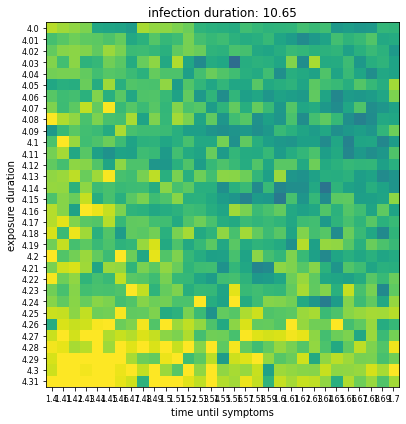

In [69]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(images[10.65], vmin=0.45, vmax=0.55)
ax.set_yticks(range(len(exposure_durations)))
ax.set_yticklabels(exposure_durations, fontsize=8)
ax.set_xticks(range(len(times_until_symtoms)))
ax.set_xticklabels(times_until_symtoms, fontsize=8)
ax.set_xlabel("time until symptoms")
ax.set_ylabel("exposure duration")
ax.set_title(f"infection duration: {infection_duration}")
fig.tight_layout()

### Epi parameter distribution plot

In [70]:
curr_epi_params = {
        "exposure_duration":{"mean":best_e_mean_veryfine, "std":best_e_std_veryfine},
        "time_until_symptoms":{"mean":best_t_mean_veryfine, "std":best_t_std_veryfine},
        "infection_duration":{"mean":best_i_mean_veryfine, "std":best_i_std_veryfine}
    }
for param_name in curr_epi_params.keys():
    mu = curr_epi_params[param_name]["mean"]
    var = curr_epi_params[param_name]["std"]**2
    shape = root_scalar(get_weibull_shape, args=(mu, var),
                method='toms748', bracket=[0.2, 500]).root
    scale = get_weibull_scale(mu, shape)
    curr_epi_params[param_name]["shape"] = shape
    curr_epi_params[param_name]["scale"] = scale

exposure_duration = []
time_until_symptoms = []
infection_duration = []
for i in range(10000):
    tmp_epi_params = {}
    while True:
        for param_name in curr_epi_params.keys():
            tmp_epi_params[param_name] = \
                round(weibull_two_param(curr_epi_params[param_name]["shape"],
                                        curr_epi_params[param_name]["scale"]))

        if (tmp_epi_params['exposure_duration'] >= 1) and \
           (tmp_epi_params['time_until_symptoms'] >= \
           tmp_epi_params['exposure_duration']) and\
           (tmp_epi_params['infection_duration'] >= \
           tmp_epi_params['time_until_symptoms']):
           break

    exposure_duration.append(tmp_epi_params['exposure_duration'])
    time_until_symptoms.append(tmp_epi_params['time_until_symptoms'])
    infection_duration.append(tmp_epi_params['infection_duration'])

exposure_duration = np.asarray(exposure_duration)
time_until_symptoms = np.asarray(time_until_symptoms)
infection_duration = np.asarray(infection_duration)

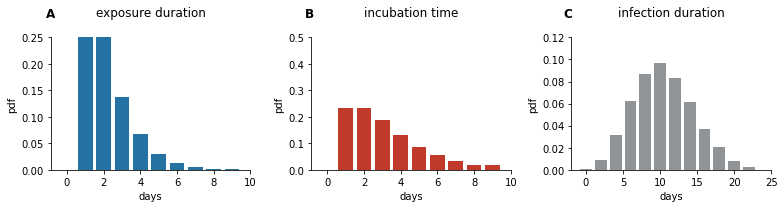

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
fig.subplots_adjust(wspace=0.3)
max_bins = [11, 11, 26]
steps = [1, 1, 2]
colors = ['#2471A3', '#C0392B', '#909497']
xticks = [range(0, 11, 2), range(0, 11, 2), range(0, 26, 5)]
labels = ['exposure duration\n', 'incubation time\n', 'infection duration\n']
ymaxes = [0.25, 0.5, 0.12]

for ax, max_bin, step, color, xtick, label, ymax, param in zip(axes, max_bins, steps, colors,\
    xticks, labels, ymaxes, [exposure_duration, time_until_symptoms, infection_duration]):
    ax.hist(param, bins=range(0, max_bin, step), rwidth=0.8, color=color,
            density=True, align='left')
    ax.set_xticks(xtick)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(label)
    ax.set_ylabel('pdf')
    ax.set_xlabel('days')
    ax.set_ylim(0, ymax)

fig.tight_layout()
fig.text(0.062, 0.9, 'A', fontsize=12, fontweight='bold')
fig.text(0.39, 0.9, 'B', fontsize=12, fontweight='bold')
fig.text(0.7162, 0.9, 'C', fontsize=12, fontweight='bold')
plt.savefig("../../../plots/epi_param_distributions.pdf")
plt.savefig("../../../plots/epi_param_distributions.svg")
plt.savefig("../../../plots/epi_param_distributions.png", dpi=300)